# Logistic Regression for Breast Cancer Diagnosis

This notebook trains a logistic regression model using cross-validation to classify breast cancer cases. It evaluates the model using accuracy, classification reports, ROC curves, and feature importance plots.

## Import required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

## Load preprocessed (scaled) data

In [2]:
X_train_scaled = np.load(os.path.join('..', 'data', 'X_train_scaled.npy'))
X_test_scaled = np.load(os.path.join('..', 'data', 'X_test_scaled.npy'))
y_train = np.load(os.path.join('..', 'data', 'y_train.npy'))
y_test = np.load(os.path.join('..', 'data', 'y_test.npy'))

## Train Logistic Regression model with Cross-Validation (Finds the best C)

In [3]:
# solver='saga': A fast solver that works well with L2 penalty.
logistic_regression_model = LogisticRegressionCV(penalty='l2', solver='saga', cv=5, Cs=10, random_state=42, max_iter=10000)

logistic_regression_model.fit(X_train_scaled, y_train)

,Cs,10
,fit_intercept,True
,cv,5
,dual,False
,penalty,'l2'
,scoring,None
,solver,'saga'
,tol,0.0001
,max_iter,10000
,class_weight,None
,n_jobs,None


## Model Evaluation

### Predictions and accuracy

In [4]:
y_pred = logistic_regression_model.predict(X_test_scaled)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print(f'Accuracy: {accuracy} \n')
print(f'Best C (inverse of regularization strength): {logistic_regression_model.C_} \n')
print(f'Coefficients: {logistic_regression_model.coef_} \n')

Accuracy: 0.9707602339181286 

Best C (inverse of regularization strength): [2.7825594] 

Coefficients: [[ 0.11303019  0.45607444  0.14255452  0.35382417  0.55375495 -0.97582755
   1.20168424  1.20739891 -0.50534884  0.09843674  1.87587541 -0.75371957
   1.16299947  1.34544053  0.32178897 -1.34713075 -0.26646588  0.7589043
  -0.55401156 -0.69297243  1.02989409  1.9593749   0.81781803  1.15683535
   0.35018012 -0.40039642  1.20582674  0.79799174  1.53140968 -0.00909403]] 



### Confusion Matrix and Classification Report

Evaluate the performance of the model using a confusion matrix and detailed classification metrics.


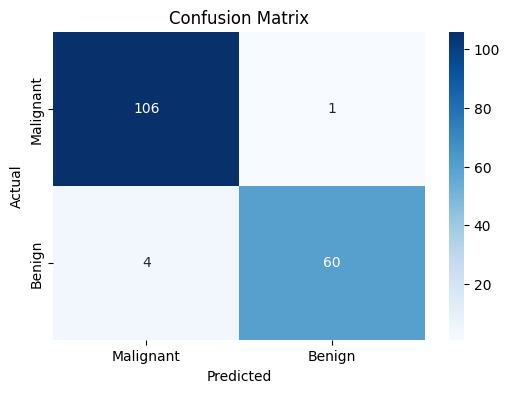


 Classification Report:
              precision    recall  f1-score   support

   Malignant       0.96      0.99      0.98       107
      Benign       0.98      0.94      0.96        64

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



In [5]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Malignant','Benign'], yticklabels=['Malignant','Benign'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\n Classification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=['Malignant', 'Benign']))


### ROC Curve and Compute AUC

The Receiver Operating Characteristic (ROC) curve helps visualize the trade-off between true positive and false positive rates at different thresholds.

The AUC (Area Under Curve) summarizes the model’s ability to distinguish between classes.

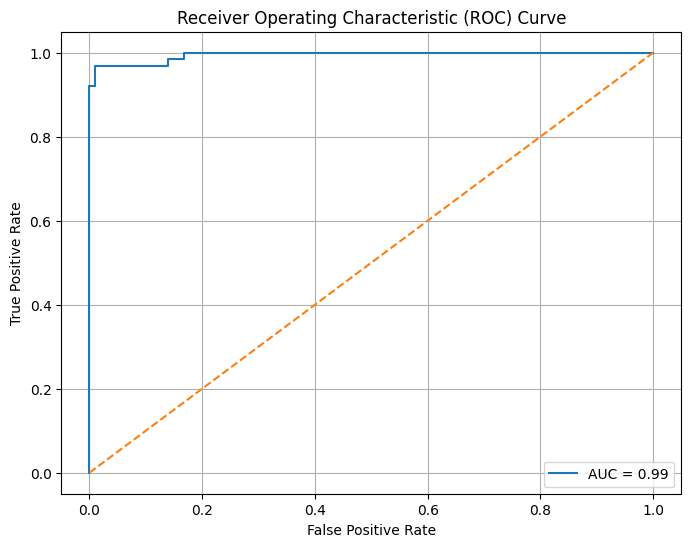

In [6]:
# Compute ROC curve and AUC
y_prob = logistic_regression_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()



## Feature Importance Visualization

While L2 regularization tends to shrink coefficients towards zero, it rarely makes them exactly zero.

In [7]:
feature_names = joblib.load(os.path.join('..', 'models', 'feature_names.joblib'))

# Binary classification have one set of coefficients, extract non-zero coefficients and feature names.
coefs = logistic_regression_model.coef_[0]
non_zero_indices = np.where(logistic_regression_model.coef_[0] != 0)[0]

non_zero_coefs = coefs[non_zero_indices]
non_zero_features = [feature_names[i] for i in non_zero_indices]
print(non_zero_features)

['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


### Top features coefficients

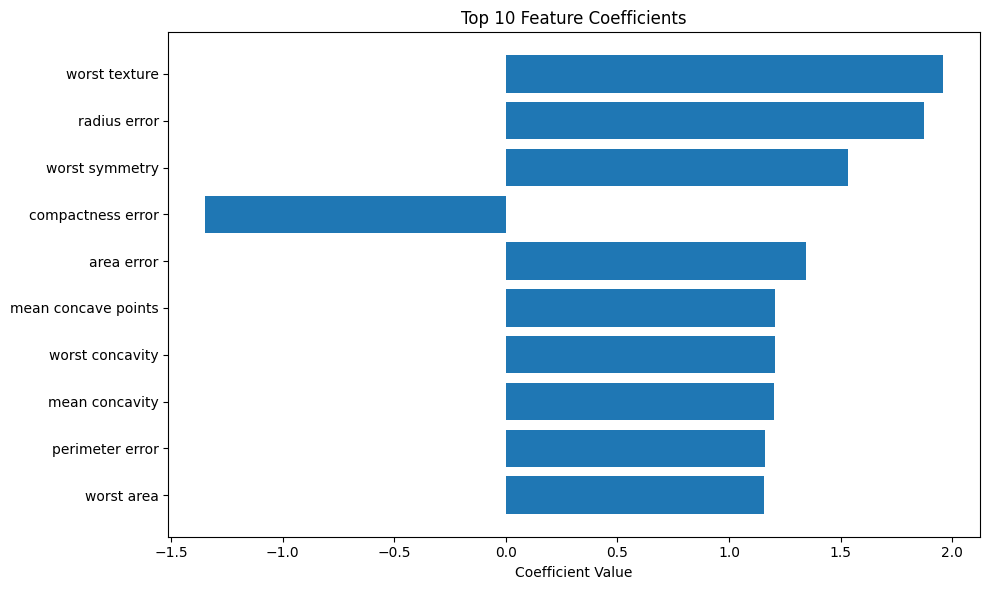

In [8]:
# Sort by absolute value
sorted_idx = np.argsort(np.abs(non_zero_coefs))[::-1]
sorted_features = [non_zero_features[i] for i in sorted_idx]
sorted_coefs = non_zero_coefs[sorted_idx]

# Plot top 10 features
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:top_n], sorted_coefs[:top_n])
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Feature Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

## Cross-Validation Scores

Visualize the cross-validation scores to assess model stability across folds.

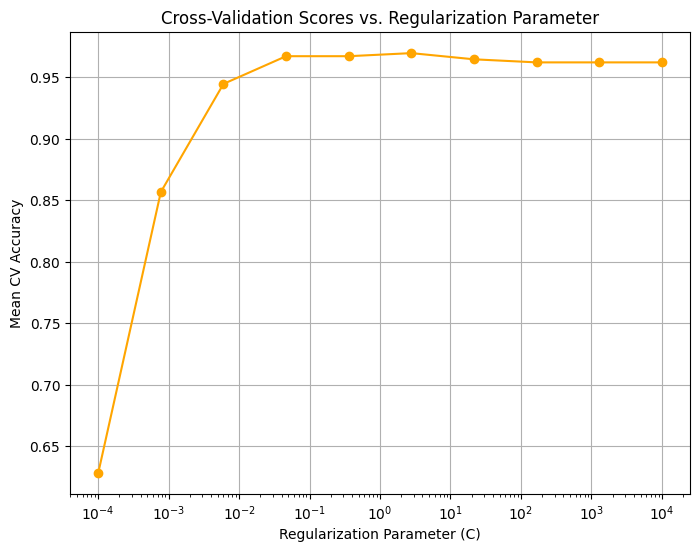

Cross-validation scores for each C value:
C = 0.0001: Mean CV Accuracy = 0.6282
C = 0.0008: Mean CV Accuracy = 0.8568
C = 0.0060: Mean CV Accuracy = 0.9447
C = 0.0464: Mean CV Accuracy = 0.9672
C = 0.3594: Mean CV Accuracy = 0.9672
C = 2.7826: Mean CV Accuracy = 0.9697
C = 21.5443: Mean CV Accuracy = 0.9647
C = 166.8101: Mean CV Accuracy = 0.9622
C = 1291.5497: Mean CV Accuracy = 0.9622
C = 10000.0000: Mean CV Accuracy = 0.9622


In [9]:
# Extract cross-validation scores for the positive class
cv_scores = logistic_regression_model.scores_[1].mean(axis=0)

# Plot CV scores
plt.figure(figsize=(8, 6))
plt.plot(logistic_regression_model.Cs_, cv_scores, marker='o', color='orange')
plt.xscale('log')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Mean CV Accuracy')
plt.title('Cross-Validation Scores vs. Regularization Parameter')
plt.grid(True)
plt.show()

print("Cross-validation scores for each C value:")
for c, score in zip(logistic_regression_model.Cs_, cv_scores):
    print(f"C = {c:.4f}: Mean CV Accuracy = {score:.4f}")

## Misclassified Samples

In [10]:
misclassified_indices = np.where(y_test != y_pred)[0]
print("Number of misclassified samples:", len(misclassified_indices))

# Show first few misclassified samples
for idx in misclassified_indices[:5]:
    print(f"Index {idx} - True: {y_test[idx]}, Predicted: {y_pred[idx]}")


Number of misclassified samples: 5
Index 29 - True: 0, Predicted: 1
Index 46 - True: 1, Predicted: 0
Index 135 - True: 1, Predicted: 0
Index 148 - True: 1, Predicted: 0
Index 168 - True: 1, Predicted: 0


## Save the model

In [11]:
try:
    joblib.dump(logistic_regression_model, os.path.join('..', 'models', 'log_reg_model.joblib'))
    print("Model saved successfully.")
except Exception as e:
    print(f"Error saving model: {e}")

Model saved successfully.
